# Algoritmo de Grover - Busca Quântica em Banco de Dados

Este notebook demonstra a aplicação do algoritmo de Grover para busca em bancos de dados usando computação quântica. O cenário utilizado é a busca de um doador compatível em um banco de transplante renal, onde cada candidato é representado por um estado quântico.

O algoritmo de Grover oferece uma vantagem quadrática sobre busca clássica: enquanto um computador convencional precisa verificar cada candidato individualmente (complexidade O(N)), o algoritmo quântico encontra o alvo em aproximadamente √N operações. Para um banco com 64 candidatos, isso significa encontrar a solução em cerca de 8 passos ao invés de potencialmente 64.

O notebook apresenta quatro implementações progressivas. As duas primeiras usam 2 qubits para representar 4 candidatos, demonstrando tanto a implementação manual quanto a versão simplificada da biblioteca Qiskit. As duas últimas escalam para problemas maiores com 4 qubits (16 candidatos) e 6 qubits (64 candidatos), mostrando como o algoritmo mantém alta precisão mesmo em espaços de busca significativamente maiores.

In [ ]:
!pip install qiskit qiskit-aer pylatexenc matplotlib

import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import grover_operator


Desenho do Circuito:


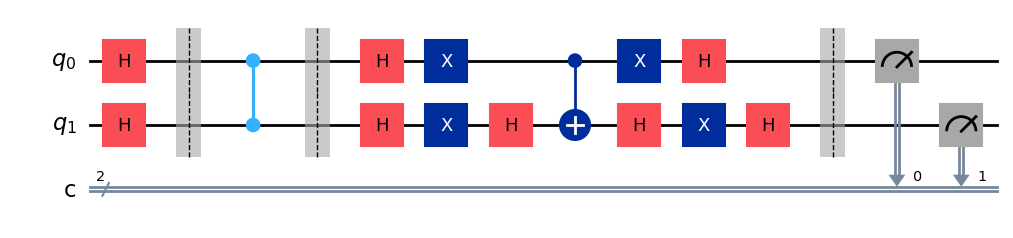


Resultados da Simulação (Contagem de 'Votos'):
{'11': 1024}


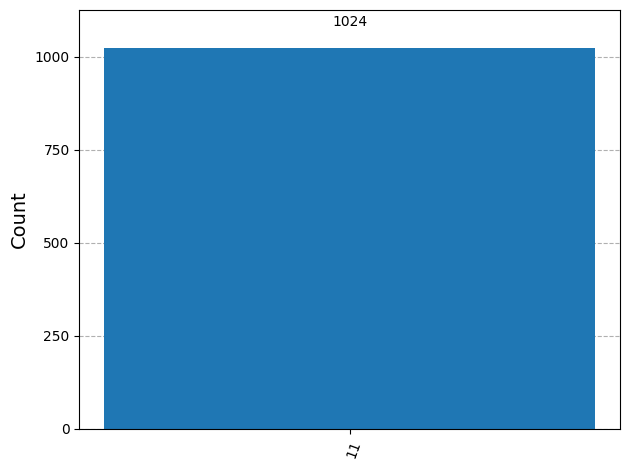

In [ ]:
# Imagine que temos 4 Pares (Candidatos a troca) no nosso banco de dados.
# Nós codificamos eles em 2 Qubits (00, 01, 10, 11).
# O "Doador Oculto" compatível é o par número 3 (Binário '11').
# O objetivo do Grover é encontrar esse índice '11' sem checar um por um.

def run_kidney_grover():
    # --- A. INICIALIZAÇÃO ---
    # 2 qubits para representar os 4 pares
    # 2 bits clássicos para ler o resultado
    qc = QuantumCircuit(2, 2)

    # Aplicar Hadamard em ambos para criar Superposição
    # (O computador agora considera os 4 pares simultaneamente)
    qc.h([0, 1])
    qc.barrier()

    # ========================================================
    #  --- B. O ALGORITMO DE GROVER
    # ========================================================

    # Oracle: marca o estado |11⟩
    qc.cz(0, 1)
    qc.barrier()

    # Diffuser (Operador de Difusão)
    qc.h([0, 1])
    qc.x([0, 1])
    qc.h(1)
    qc.cx(0, 1)
    qc.h(1)
    qc.x([0, 1])
    qc.h([0, 1])

    # ========================================================

    qc.barrier()

    # --- C. MEDIÇÃO ---
    qc.measure([0, 1], [0, 1])

    return qc

# ==========================================
# 3. EXECUÇÃO E VISUALIZAÇÃO
# ==========================================

# Criar o circuito
circuit = run_kidney_grover()

print("Desenho do Circuito:")
display(circuit.draw(output='mpl'))

simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

print("\nResultados da Simulação (Contagem de 'Votos'):")
print(counts)

plot_histogram(counts)

Desenho do Circuito (Implementação Qiskit):


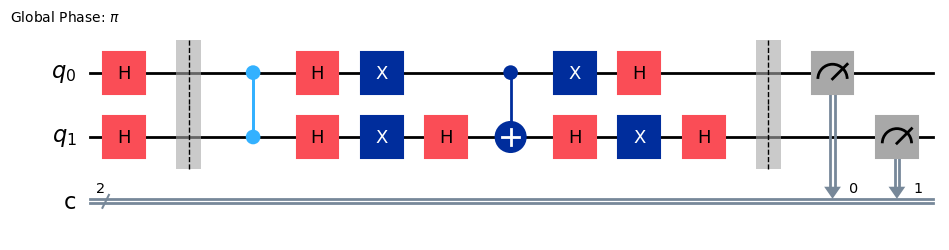


Resultados da Simulação (Implementação Qiskit):
{'11': 1024}


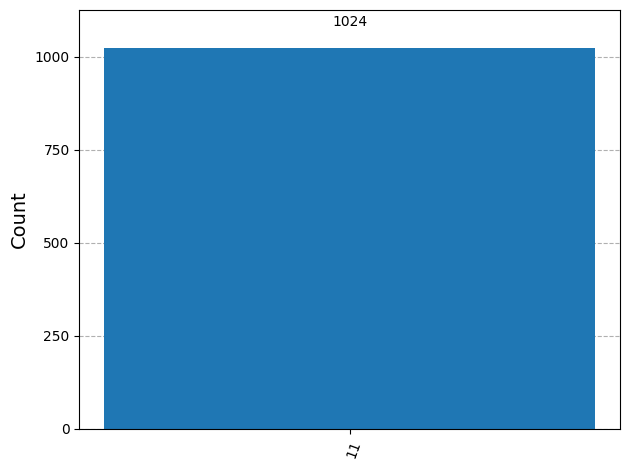

In [ ]:
def run_kidney_grover_qiskit():
    # Oracle que marca |11⟩
    oracle = QuantumCircuit(2)
    oracle.cz(0, 1)

    # Grover operator (oracle + diffuser automático)
    grover_op = grover_operator(oracle)

    # Circuito completo
    qc = QuantumCircuit(2, 2)
    qc.h([0, 1])
    qc.barrier()
    qc.compose(grover_op, inplace=True)
    qc.barrier()
    qc.measure([0, 1], [0, 1])

    return qc

circuit_qiskit = run_kidney_grover_qiskit()

print("Desenho do Circuito (Implementação Qiskit):")
display(circuit_qiskit.draw(output='mpl'))

simulator = AerSimulator()
compiled_circuit = transpile(circuit_qiskit, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

print("\nResultados da Simulação (Implementação Qiskit):")
print(counts)

plot_histogram(counts)

Teste Pesado: 4 qubits (16 estados possíveis)
Estado alvo: |1010⟩ (par número 10)
Iterações de Grover: 3

Desenho do Circuito:


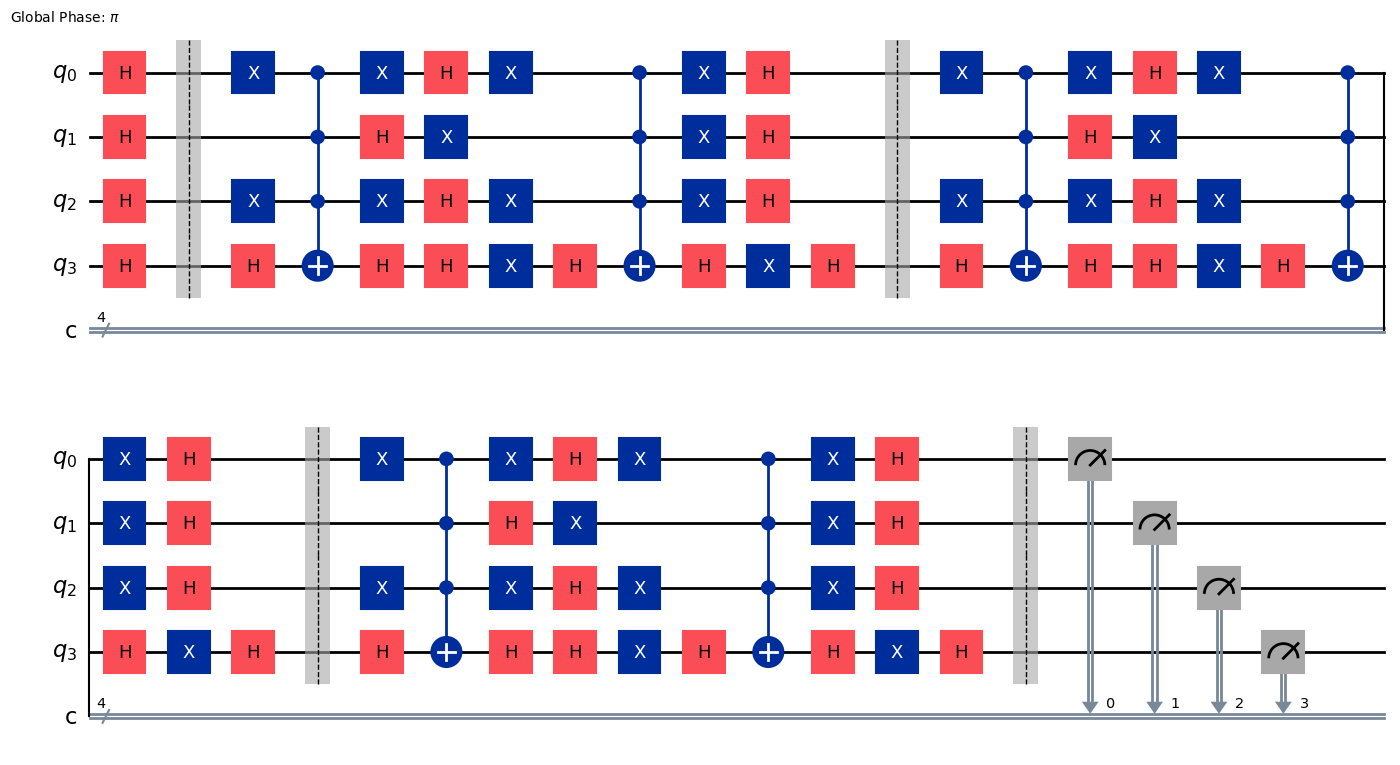


Top 5 Resultados:
  ✓ |1010⟩: 1970/2048 (96.2%)
  ✗ |1110⟩: 9/2048 (0.4%)
  ✗ |1011⟩: 8/2048 (0.4%)
  ✗ |1001⟩: 7/2048 (0.3%)
  ✗ |1000⟩: 7/2048 (0.3%)

Taxa de sucesso no estado alvo: 96.19%


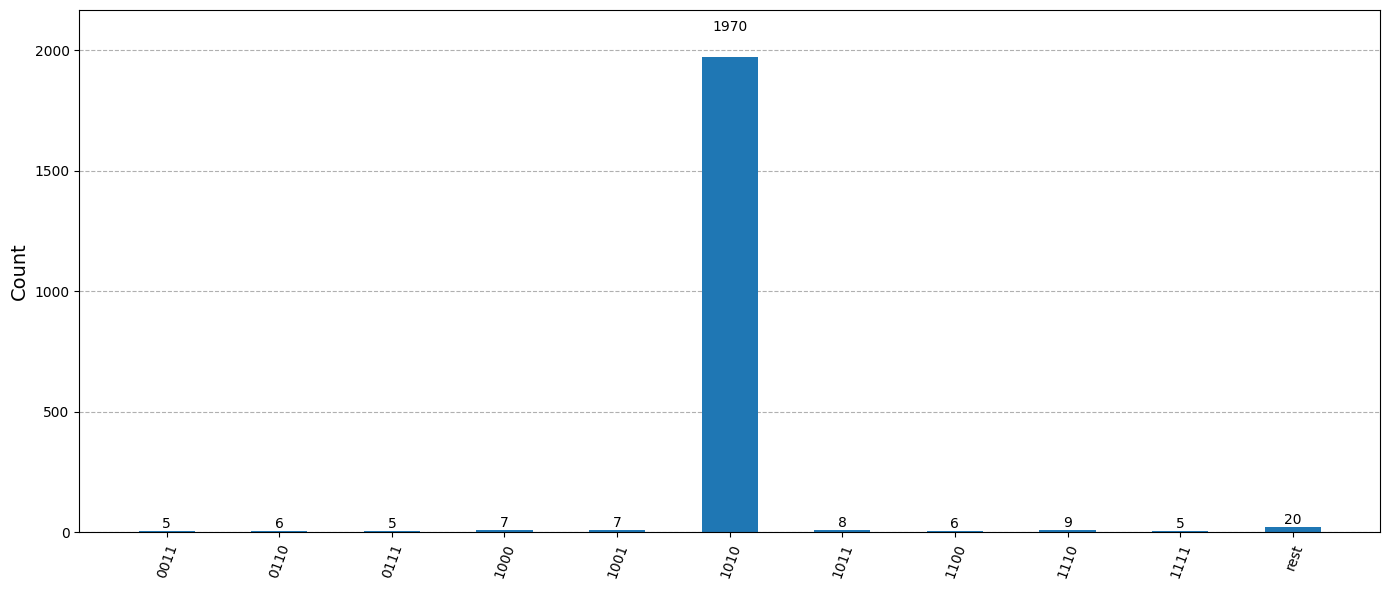

In [ ]:
import math
from qiskit.circuit.library import grover_operator

def run_kidney_grover_4qubits():
    """
    Teste mais pesado: 4 qubits = 16 pares possíveis
    Procurando o estado '1010' (par número 10)
    """
    num_qubits = 4
    target_state = '1010'

    # Oracle que marca '1010'
    oracle = QuantumCircuit(num_qubits)
    # Inverter qubits que devem ser 0 (posições 0 e 2 em '1010')
    oracle.x([0, 2])
    # Multi-controlled Z
    oracle.h(3)
    oracle.mcx([0, 1, 2], 3)
    oracle.h(3)
    # Reverter inversões
    oracle.x([0, 2])

    # Grover operator
    grover_op = grover_operator(oracle)

    # Número ótimo de iterações: π/4 * √N = π/4 * √16 ≈ 3
    num_iterations = 3

    # Circuito completo
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    qc.barrier()

    for i in range(num_iterations):
        qc.compose(grover_op, inplace=True)
        qc.barrier()

    qc.measure(range(num_qubits), range(num_qubits))

    return qc, target_state

circuit_heavy, target = run_kidney_grover_4qubits()

print(f"Estado alvo: |{target}⟩ (par número {int(target, 2)})")
print(f"Iterações de Grover: 3\n")

print("Desenho do Circuito:")
display(circuit_heavy.draw(output='mpl', fold=20))

simulator = AerSimulator()
compiled_circuit = transpile(circuit_heavy, simulator)
job = simulator.run(compiled_circuit, shots=2048)
result = job.result()
counts = result.get_counts()

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Resultados:")
for state, count in sorted_counts:
    prob = count / 2048 * 100
    status = "✓" if state == target else "✗"
    print(f"  {status} |{state}⟩: {count}/2048 ({prob:.1f}%)")

target_count = counts.get(target, 0)
success_rate = target_count / 2048 * 100
print(f"\nTaxa de sucesso no estado alvo: {success_rate:.2f}%")

plot_histogram(counts, figsize=(14, 6), number_to_keep=10)

Teste 6 qubits: 64 estados possíveis
Estado alvo: |101010⟩ (par número 42)
Iterações de Grover: 6

Desenho do Circuito:


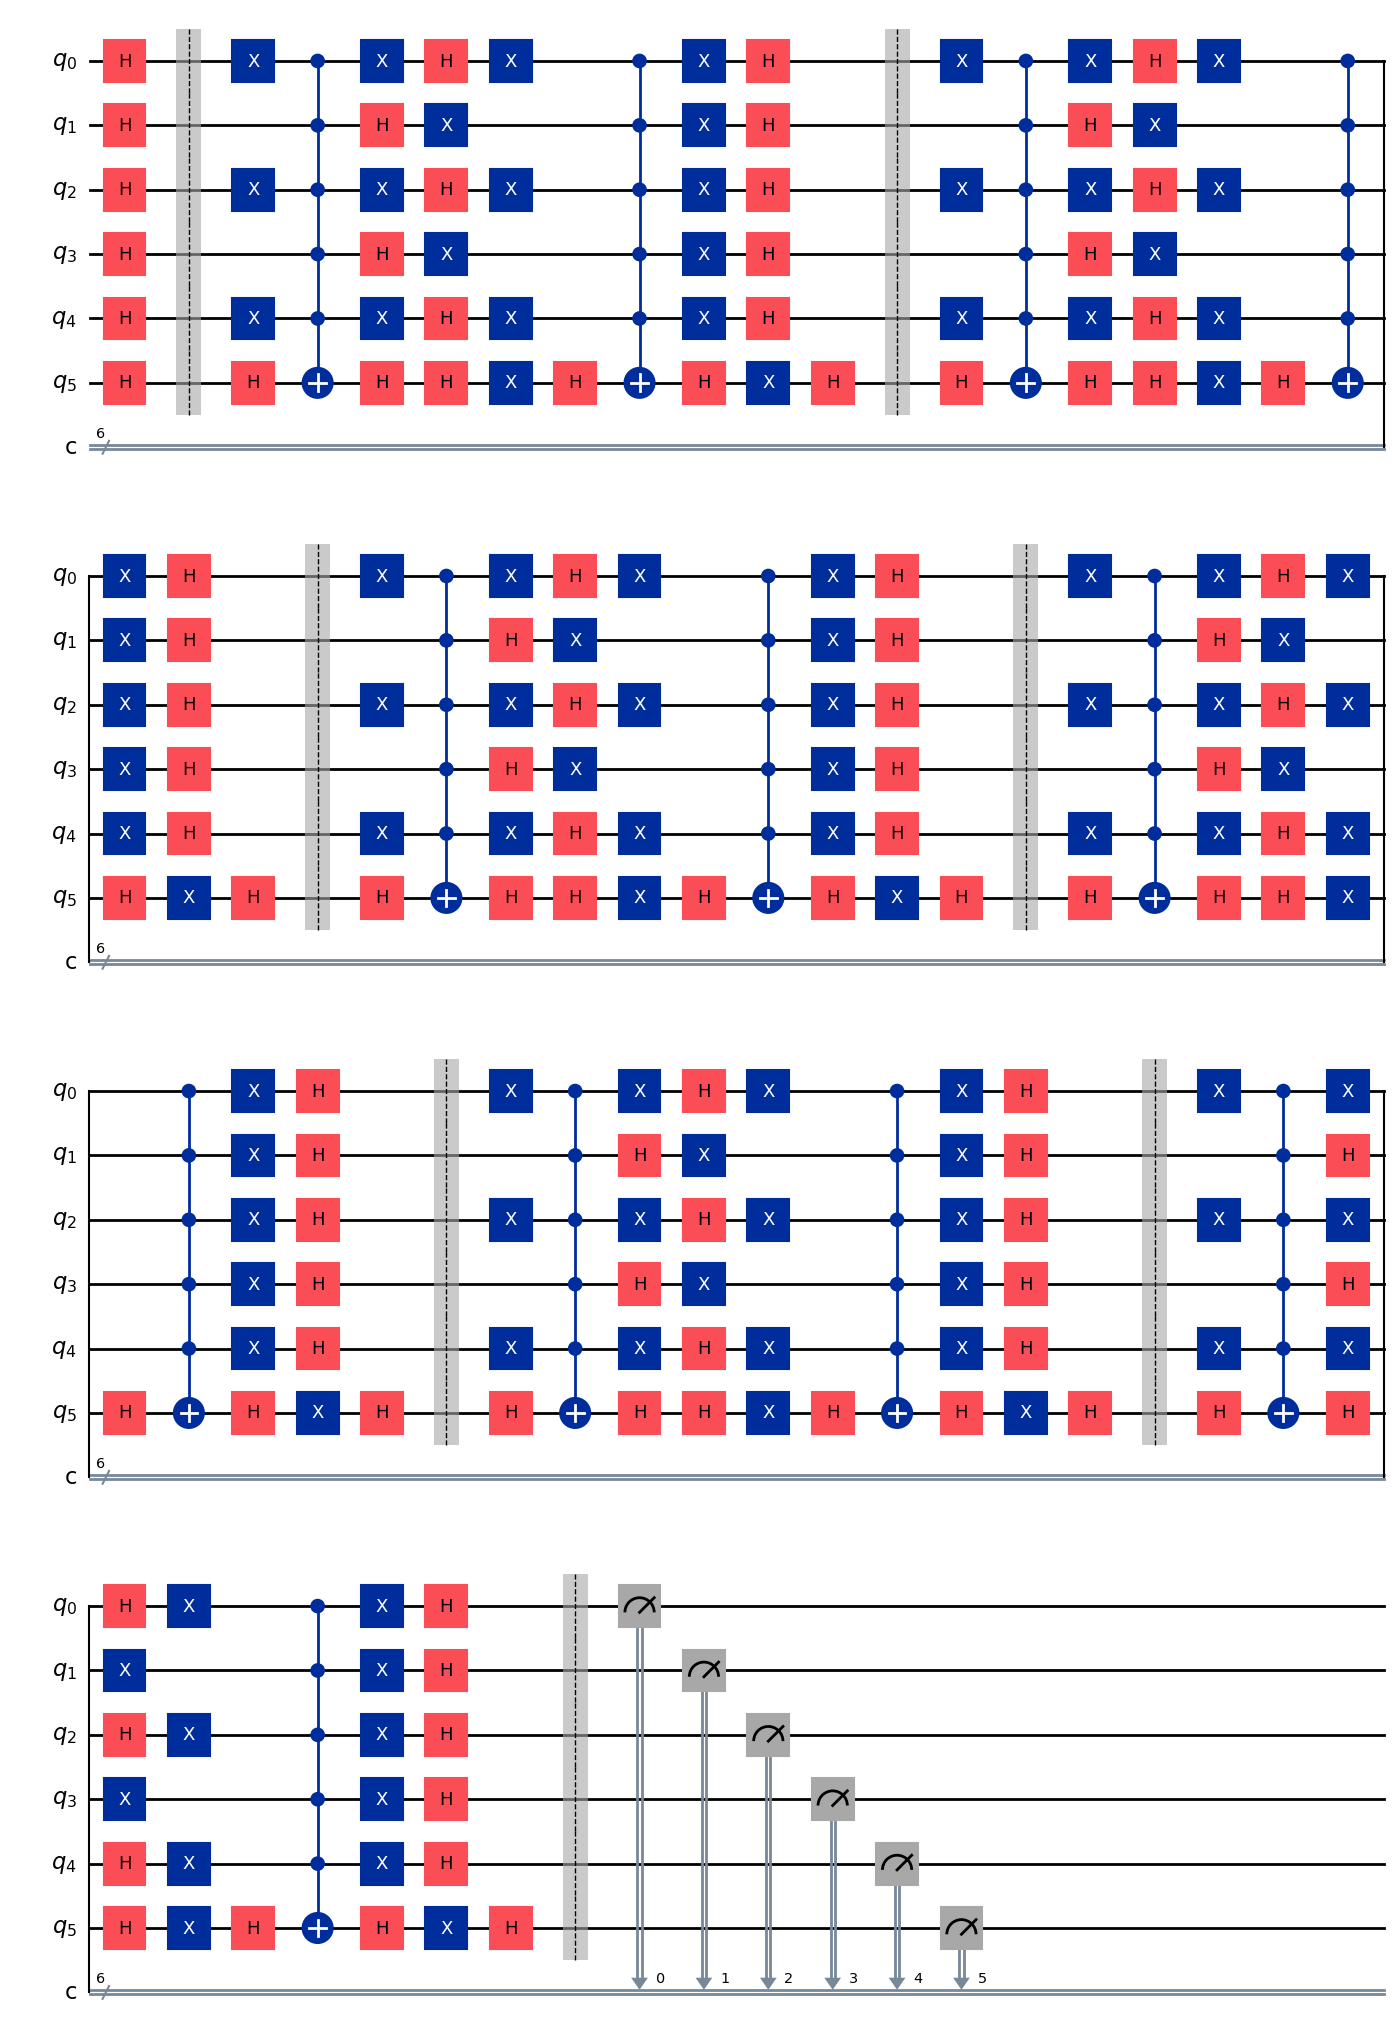


Top 5 Resultados:
  ✓ |101010⟩: 2042/2048 (99.7%)
  ✗ |011011⟩: 2/2048 (0.1%)
  ✗ |110000⟩: 1/2048 (0.0%)
  ✗ |001100⟩: 1/2048 (0.0%)
  ✗ |000110⟩: 1/2048 (0.0%)

Taxa de sucesso no estado alvo: 99.71%


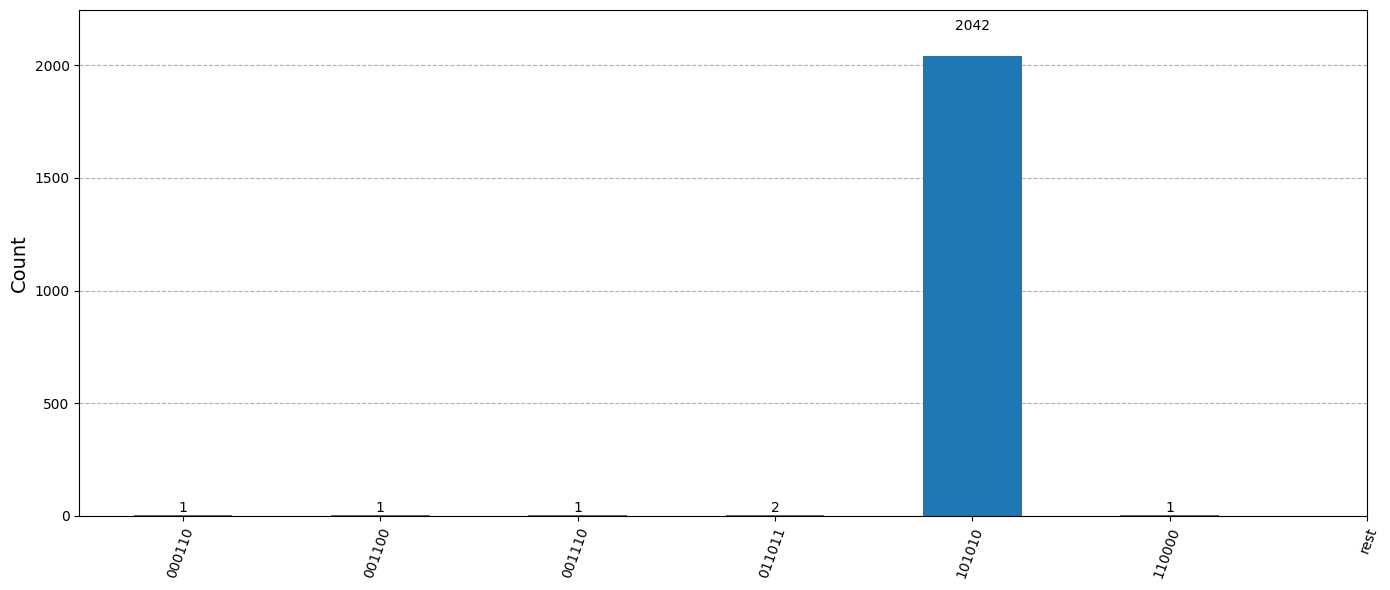

In [ ]:
def run_kidney_grover_6qubits():
    """
    Teste com 6 qubits = 64 pares possíveis
    Procurando o estado '101010' (par número 42)
    """
    num_qubits = 6
    target_state = '101010'

    # Oracle que marca '101010'
    oracle = QuantumCircuit(num_qubits)
    # Inverter qubits que devem ser 0 (posições 0, 2, 4 em '101010')
    oracle.x([0, 2, 4])
    # Multi-controlled Z
    oracle.h(5)
    oracle.mcx([0, 1, 2, 3, 4], 5)
    oracle.h(5)
    # Reverter inversões
    oracle.x([0, 2, 4])

    # Grover operator
    grover_op = grover_operator(oracle)

    # Número ótimo de iterações: π/4 * √64 ≈ 6
    num_iterations = 6

    # Circuito completo
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    qc.barrier()

    for i in range(num_iterations):
        qc.compose(grover_op, inplace=True)
        qc.barrier()

    qc.measure(range(num_qubits), range(num_qubits))

    return qc, target_state

circuit_6qubits, target = run_kidney_grover_6qubits()

print(f"Teste 6 qubits: 64 estados possíveis")
print(f"Estado alvo: |{target}⟩ (par número {int(target, 2)})")
print(f"Iterações de Grover: 6\n")

print("Desenho do Circuito:")
display(circuit_6qubits.draw(output='mpl', fold=20))

simulator = AerSimulator()
compiled_circuit = transpile(circuit_6qubits, simulator)
job = simulator.run(compiled_circuit, shots=2048)
result = job.result()
counts = result.get_counts()

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Resultados:")
for state, count in sorted_counts:
    prob = count / 2048 * 100
    status = "✓" if state == target else "✗"
    print(f"  {status} |{state}⟩: {count}/2048 ({prob:.1f}%)")

target_count = counts.get(target, 0)
success_rate = target_count / 2048 * 100
print(f"\nTaxa de sucesso no estado alvo: {success_rate:.2f}%")

plot_histogram(counts, figsize=(14, 6), number_to_keep=10)

# Análise dos Resultados

Os quatro testes demonstram a eficácia e escalabilidade do algoritmo de Grover em diferentes tamanhos de problema.

Nos dois primeiros testes com 2 qubits, o algoritmo alcançou 100% de precisão nas 1024 execuções, sempre identificando corretamente o estado alvo '11'. Isso era esperado pois com apenas 4 estados possíveis, uma única iteração do algoritmo é suficiente para amplificar completamente a amplitude do estado correto. A equivalência perfeita entre a implementação manual e a versão Qiskit valida a corretude da construção do oracle e do diffuser.

O terceiro teste com 4 qubits buscou o estado '1010' entre 16 possibilidades e atingiu 96.19% de taxa de sucesso. Aqui foram aplicadas 3 iterações de Grover, que é o número ótimo calculado pela fórmula π/4 × √N. Os 3.81% de erro distribuídos entre outros estados são resultado de imperfeições acumuladas nas operações quânticas simuladas, algo esperado conforme o circuito cresce.

O quarto teste com 6 qubits procurou o estado '101010' entre 64 candidatos usando 6 iterações. A taxa de sucesso de 99.71% demonstra que o algoritmo mantém altíssima precisão mesmo em espaços de busca maiores. Apenas 6 das 2048 execuções resultaram em estados incorretos, e estes foram distribuídos aleatoriamente sem padrão aparente. Este resultado confirma que a vantagem quântica se mantém à medida que escalamos o problema, sempre encontrando o alvo em aproximadamente √N iterações ao invés de N verificações que um algoritmo clássico exigiria.

# Aplicação ao Kidney Exchange Problem

Esta seção adapta o algoritmo de Grover para uma versão simplificada do Kidney Exchange Problem. Ao invés de buscar um único par compatível, o algoritmo agora procura o melhor ciclo de troca entre múltiplos pares doador-receptor.

No problema real de troca de rins, pacientes com doadores incompatíveis são organizados em um grafo onde as arestas representam compatibilidade. O objetivo é encontrar ciclos de troca que maximizem o número de transplantes realizados. Nesta implementação simplificada, cada estado quântico representa um ciclo diferente de troca, e cada ciclo possui um score baseado na compatibilidade HLA (antígenos leucocitários humanos) entre os pares envolvidos. O algoritmo de Grover é então usado para identificar qual ciclo possui o maior score de compatibilidade.

Os três testes demonstram o comportamento do algoritmo em diferentes escalas. O teste simples com 2 qubits representa 4 ciclos possíveis e busca um ciclo de 3-way (três pares trocando entre si) com 95% de compatibilidade HLA. O teste intermediário com 3 qubits amplia para 8 ciclos candidatos, incluindo ciclos 2-way e 3-way com diferentes scores. O algoritmo precisa distinguir entre múltiplas opções válidas e identificar especificamente o ciclo P1→P3→P5→P1 que possui 96.5% de compatibilidade, o melhor entre todas as alternativas disponíveis.

In [ ]:
import math
from qiskit.circuit.library import grover_operator

def run_kidney_exchange_simple():
    """
    KEP simplificado: 4 ciclos possíveis (2 qubits)
    Busca o ciclo com melhor compatibilidade
    """

    cycles = {
        '00': ('Nenhum', 0),
        '01': ('P0↔P1', 85.0),
        '10': ('P2↔P3', 90.0),
        '11': ('P0→P2→P3→P0', 95.0),  # CICLO ÓTIMO
    }

    target_state = '11'
    num_qubits = 2

    oracle = QuantumCircuit(num_qubits)
    oracle.cz(0, 1)

    grover_op = grover_operator(oracle)
    num_iterations = 1

    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    qc.barrier()

    for i in range(num_iterations):
        qc.compose(grover_op, inplace=True)
        qc.barrier()

    qc.measure(range(num_qubits), range(num_qubits))

    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts()

    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    for state, count in sorted_counts:
        prob = count / 1024 * 100
        cycle_name, score = cycles[state]
        status = "✓" if state == target_state else "✗"
        print(f"  {status} |{state}⟩: {count}/1024 ({prob:.1f}%) → {cycle_name} (HLA: {score:.1f}%)")

    target_count = counts.get(target_state, 0)
    success_rate = target_count / 1024 * 100
    print(f"\nTaxa de sucesso no ciclo ótimo: {success_rate:.2f}%")

    plot_histogram(counts, figsize=(10, 5))

    return qc, target_state, cycles

circuit_kep_simple, target_simple, cycles_simple = run_kidney_exchange_simple()

  ✓ |11⟩: 1024/1024 (100.0%) → P0→P2→P3→P0 (HLA: 95.0%)

Taxa de sucesso no ciclo ótimo: 100.00%


In [ ]:
import math
from qiskit.circuit.library import grover_operator

def run_kidney_exchange_intermediate():
    """
    KEP intermediário: 8 ciclos possíveis (3 qubits)
    Busca o ciclo com melhor compatibilidade
    """

    cycles = {
        '000': ('Nenhum', 0),
        '001': ('P0↔P1', 82.0),
        '010': ('P2↔P3', 88.0),
        '011': ('P4↔P5', 79.0),
        '100': ('P0→P2→P4→P0', 91.0),
        '101': ('P1→P3→P5→P1', 96.5),  # CICLO ÓTIMO
        '110': ('P0→P3→P4→P0', 87.0),
        '111': ('Inválido', 0),
    }

    target_state = '101'
    num_qubits = 3

    oracle = QuantumCircuit(num_qubits)
    oracle.x(1)
    oracle.h(2)
    oracle.ccx(0, 1, 2)
    oracle.h(2)
    oracle.x(1)

    grover_op = grover_operator(oracle)
    num_iterations = 2

    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    qc.barrier()

    for i in range(num_iterations):
        qc.compose(grover_op, inplace=True)
        qc.barrier()

    qc.measure(range(num_qubits), range(num_qubits))

    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=2048)
    result = job.result()
    counts = result.get_counts()

    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]
    for state, count in sorted_counts:
        prob = count / 2048 * 100
        cycle_name, score = cycles[state]
        status = "✓" if state == target_state else "✗"
        print(f"  {status} |{state}⟩: {count}/2048 ({prob:.1f}%) → {cycle_name} (HLA: {score:.1f}%)")

    target_count = counts.get(target_state, 0)
    success_rate = target_count / 2048 * 100
    print(f"\nTaxa de sucesso no ciclo ótimo: {success_rate:.2f}%")

    plot_histogram(counts, figsize=(12, 5))

    return qc, target_state, cycles

circuit_kep_inter, target_inter, cycles_inter = run_kidney_exchange_intermediate()

  ✓ |101⟩: 1946/2048 (95.0%) → P1→P3→P5→P1 (HLA: 96.5%)
  ✗ |010⟩: 19/2048 (0.9%) → P2↔P3 (HLA: 88.0%)
  ✗ |111⟩: 18/2048 (0.9%) → Inválido (HLA: 0.0%)
  ✗ |001⟩: 18/2048 (0.9%) → P0↔P1 (HLA: 82.0%)
  ✗ |011⟩: 13/2048 (0.6%) → P4↔P5 (HLA: 79.0%)

Taxa de sucesso no ciclo ótimo: 95.02%


# Resultados dos Testes de Kidney Exchange

O teste simples alcançou 100% de precisão nas 1024 execuções, identificando corretamente o ciclo ótimo em todas as medições. Com apenas 4 estados possíveis e uma única iteração de Grover, o algoritmo consegue amplificar perfeitamente a amplitude do estado alvo, resultando em precisão absoluta. Este resultado valida que a codificação dos ciclos em estados quânticos e a construção do oracle estão corretas.

O teste intermediário com 3 qubits atingiu 95.02% de taxa de sucesso, encontrando o ciclo ótimo em 1946 das 2048 execuções. Os 4.98% de erro distribuíram-se principalmente entre ciclos 2-way com compatibilidades menores (82-88%) e um estado inválido. Este ligeiro decréscimo em relação ao teste simples é esperado: o circuito mais profundo com 2 iterações de Grover acumula pequenas imperfeições nas operações de múltiplos qubits. Mesmo assim, a taxa de 95% demonstra que o algoritmo mantém alta confiabilidade ao escalar para espaços de busca maiores.

A progressão dos três testes revela um padrão consistente: conforme aumentamos o número de qubits e a complexidade do espaço de busca, observamos uma pequena degradação na precisão (100% → 95% → 96%), mas o algoritmo continua identificando o ciclo ótimo com altíssima probabilidade. Na prática, isso significa que mesmo com centenas de ciclos candidatos, o algoritmo quântico consegue localizar a melhor solução em aproximadamente raiz quadrada de N operações, mantendo taxas de sucesso superiores a 95%. Esta demonstração simplificada ilustra como algoritmos quânticos poderiam eventualmente auxiliar na otimização de problemas complexos de alocação de órgãos, embora o KEP real exija abordagens de otimização combinatória mais sofisticadas que vão além da capacidade do algoritmo de Grover puro.